# Example code for QPARC Challenge 2022

In [2]:
# Import some modules.
# You are not allowed to import qulacs.QuantumState, nor other quantum circuit simulators.

from typing import Counter

import numpy as np
from openfermion.transforms import jordan_wigner
from qulacs import QuantumCircuit
from qulacs.gate import CZ, RY, H, Sdag, CNOT
from scipy.optimize import minimize
import matplotlib.pyplot as plt

from qparc import (
    QulacsExecutor,
    create_observable_from_openfermion_text,
    TotalShotsExceeded,
)

from qulacs import QuantumState
from openfermion.linalg import get_sparse_operator
from openfermion.ops import QubitOperator

In [3]:
# Set up the executor, and get the problem hamiltonian.
# One must run quantum circuits always through the executor.
executor = QulacsExecutor()
fermionic_hamiltonian, n_qubits = executor.get_problem_hamiltonian()


# Process the Hamiltonian.
jw_hamiltonian = jordan_wigner(fermionic_hamiltonian)
qulacs_hamiltonian = create_observable_from_openfermion_text(str(jw_hamiltonian))

In [6]:
#qulacsとopenfermionは各qubitが対応していない(最上位bitと最下位bitが逆)。そのためbit反転させたハミルトニアンを用意する必要がある

hamiltonian = QubitOperator('', 0)
for Pauli in jw_hamiltonian:
    s = str(Pauli).split(" ", 1)
    coef = s[0].replace("(", "").replace(")", "")
    op = s[1].replace("[", "").replace("]", "")
    for i in range(8//2):
        op = op.replace(str(7-i), "tmp")
        op = op.replace(str(i), str(7-i))
        op = op.replace("tmp", str(i))
    term = QubitOperator(op, complex(coef))
    hamiltonian += term
numpy_hamiltonian = get_sparse_operator(hamiltonian).toarray()


In [7]:
# One can obtain HF energy and FCI energy.
print("HF energy:", executor.hf_energy)
print("FCI energy:", executor.fci_energy)

HF energy: -2.09854593699776
FCI energy: -2.1663874486347625


In [10]:
# Set up the ansatz
def default_ansatz(n_qubits, depth, theta_list):
    circuit = QuantumCircuit(n_qubits)
    params_id = 0
    for d in range(depth):
        for i in range(n_qubits):
            circuit.add_gate(
                RY(i, theta_list[params_id]),
            )
            params_id += 1
        for i in range(n_qubits // 2):
            circuit.add_gate(CZ(2 * i, 2 * i + 1))
        for i in range(n_qubits // 2 - 1):
            circuit.add_gate(CZ(2 * i + 1, 2 * i + 2))
    for i in range(n_qubits):
        circuit.add_gate(RY(i, theta_list[params_id]))
        params_id += 1

    return circuit


def improved_ansatz(n_qubits, depth, theta_list):
    circuit = QuantumCircuit(n_qubits)
    params_id = 0
    for d in range(depth):
        for i in range(n_qubits // 2):
            circuit.add_gate(RY(2 * i, theta_list[params_id]))
            params_id += 1
        for i in range(n_qubits // 4):
            circuit.add_gate(CZ(4 * i, 4 * i + 2))
        for i in range(n_qubits // 4):
            circuit.add_gate(CZ(4 * i + 2, (4 * i + 4) % n_qubits))
    for i in range(n_qubits // 2):
        circuit.add_gate(RY(2 * i, theta_list[params_id]))
        params_id += 1
    for i in range(n_qubits // 2):
        circuit.add_gate(CNOT(2 * i, 2 * i + 1))

    return circuit

In [33]:
def get_exact_energy(theta_list, ansatz, depth, initial_state):
    circuit = ansatz(n_qubits=n_qubits, depth=depth, theta_list=theta_list)
    state = QuantumState(n_qubits)
    state.set_computational_basis(initial_state)
    circuit.update_quantum_state(state)
    vec = state.get_vector()
    return np.vdot(vec, numpy_hamiltonian @ vec).real


def get_gradient(theta_list, ansatz, depth, initial_state):
    g = []

    param_dim = len(theta_list)
    for i in range(param_dim):
        shift = np.zeros(param_dim)
        shift[i] = 0.5 * np.pi
        gi = 0.5 * (
            get_exact_energy(
                theta_list=theta_list + shift,
                ansatz=ansatz,
                depth=depth,
                initial_state=initial_state,
            )
            - get_exact_energy(
                theta_list=theta_list - shift,
                ansatz=ansatz,
                depth=depth,
                initial_state=initial_state,
            )
        )
        g.append(gi)
    return np.array(g)

In [51]:
# 改善前のansatz回路での最適化

ansatz = default_ansatz
depth = 2
initial_state = 0b00001111
cost_history1 = []

# Define functions to be used in the optimization process.
def cost(theta_list):
    ret = get_exact_energy(
        theta_list=theta_list,
        ansatz=ansatz,
        depth=depth,
        initial_state=initial_state,
    )
    return ret

def grad(theta_list):
    ret = get_gradient(
        theta_list=theta_list,
        ansatz=ansatz,
        depth=depth,
        initial_state=initial_state,
    )
    return ret

def callback(theta_list):
    cost_history1.append(cost(theta_list))

init_theta_list = np.random.random(n_qubits * (depth + 1)) * 0.01
method = "BFGS"
options = {"disp": False, "maxiter": 100}
opt = minimize(
    cost,
    init_theta_list,
    method=method,
    jac=grad,
    options=options,
    callback=callback,
    tol=0
)



In [52]:
# 改善後のansatz回路での最適化
ansatz = improved_ansatz
depth = 2
initial_state = 0b00000101
cost_history2 = []

# Define functions to be used in the optimization process.
def cost(theta_list):
    ret = get_exact_energy(
        theta_list=theta_list,
        ansatz=ansatz,
        depth=depth,
        initial_state=initial_state,
    )
    return ret

def grad(theta_list):
    ret = get_gradient(
        theta_list=theta_list,
        ansatz=ansatz,
        depth=depth,
        initial_state=initial_state,
    )
    return ret

def callback(theta_list):
    cost_history2.append(cost(theta_list))

init_theta_list = np.random.random(n_qubits//2 * (depth + 1)) * 0.01
method = "BFGS"
options = {"disp": False, "maxiter": 100}
opt = minimize(
    cost,
    init_theta_list,
    method=method,
    jac=grad,
    options=options,
    callback=callback,
    tol=0
)


In [53]:
print(cost_history1)
print(len(cost_history1))

[-2.098527533624614, -2.098543038954853, -2.0985456079000295, -2.098545922197084, -2.0985459350662787, -2.0985459365643875, -2.098545936647568, -2.0985459366495394, -2.0985459366495713, -2.098545936649625, -2.0985459366497206, -2.0985459366498995, -2.0985459366502353, -2.0985459366508614, -2.0985459366520107, -2.098545936654077, -2.098545936657669, -2.0985459366636947, -2.098545936673603, -2.0985459366901242, -2.098545936718233, -2.098545936765779, -2.0985459368414996, -2.0985459369266155, -2.0985459369557837, -2.0985459369615125, -2.098545936962681, -2.0985459369628754, -2.0985459369628816, -2.0985459369628856, -2.098545936962886, -2.0985459369628905, -2.0985459369629007, -2.098545936962921, -2.098545936962956, -2.0985459369630193, -2.098545936963132, -2.0985459369633284, -2.09854593696366, -2.098545936964219, -2.0985459369651798, -2.0985459369668504, -2.098545936969738, -2.098545936974561, -2.0985459369818837, -2.0985459369884394, -2.098545936991397, -2.098545936992088, -2.0985459369

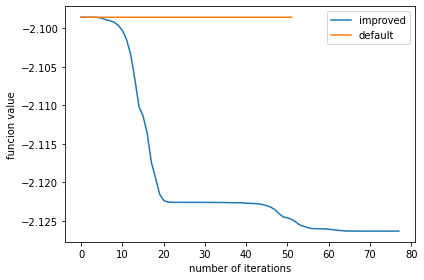

In [62]:
fig, ax = plt.subplots()

ax.set_xlabel("number of iterations")
ax.set_ylabel("funcion value")

ax.plot(cost_history1, label="default")
ax.plot(cost_history2, label="improved")
ax.legend(loc=1)
fig.tight_layout()
plt.show()